In [151]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [281]:
points = np.load('data/points.npy', allow_pickle=True)
simulations = np.load('data/simulations.npy', allow_pickle=True)[:, :, :2100]
eps = xr.load_dataarray('data/eps.nc')

import pickle
with open('data/lcc_simulations.p', 'rb') as out:
    out_dict = pickle.load(out)
    fields = out_dict['fields']
    losses = out_dict['losses']

gprmax = np.quantile(np.abs(simulations), 0.9) 
vmax = np.max(np.abs(fields[1, 0]))

U_x = np.load('data/U_x.npy', allow_pickle=True)


In [282]:
print(f'points has shape: {points.shape} = (ndim, nt, npoints)')
print(f'simulations has shape: {simulations.shape} = (nt, nz, nx)')
print(f'eps has shape: {eps.shape} = (nt, nz, nx)')
print(f'fields has shape: {fields.shape} = (nt, nd, nx, nz)')
print(f'losses has shape: {losses.shape} = (nt, niter, nloss)')
print(f'U_x has shape: {U_x.shape} = (nz, nx)')

points has shape: (2, 21, 1000) = (ndim, nt, npoints)
simulations has shape: (21, 1501, 2100) = (nt, nz, nx)
eps has shape: (21, 401, 2001) = (nt, nz, nx)
fields has shape: (21, 2, 420, 501) = (nt, nd, nx, nz)
losses has shape: (21, 20000, 3) = (nt, niter, nloss)
U_x has shape: (100, 1000) = (nz, nx)


In [283]:
# gpr simulations properties
c = 3e8
vel = c/np.sqrt(3.5)
maxdepth = 401 * 0.25

DX = 0.1
DZ = 0.1
DT = 3e-10 / 2  # because of the decimating
NT = 2100 # int(maxT/DT)
maxT = NT * DT * 2  # because of the two way travel times

In [284]:
# lcc properties
dx = 0.2 * 3

maxlag = 40 * dx
sigma = 18 * dx

print(f'maximum lag is {maxlag:.2f} m')
print(f'sigma is {sigma:.2f} m')

maximum lag is 24.00 m
sigma is 10.80 m


In [286]:
%matplotlib qt
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig = plt.figure(figsize=(8, 8))

width = 0.8
height = 0.44
ax0 = fig.add_axes([(1 - width)/2, 0.95 - height, width, height])

ax0.xaxis.tick_top()

ti = 0
text = ax0.text(0.01, 0.01, f't = 0.0 a', ha='left', va='bottom', transform=ax0.transAxes)

simul_im = ax0.imshow(simulations[ti].T, vmin=-gprmax, vmax=gprmax, cmap='Greys', extent=[100, 400, maxT * vel, 0], aspect='auto')
eps_im = ax0.imshow(eps[ti][::-1], extent=[0, 500, 100, 0], aspect='auto', alpha=0.3)

x0 = fig.transFigure.inverted().transform(ax0.transData.transform([100, 0]))[0]
x1 = fig.transFigure.inverted().transform(ax0.transData.transform([400, 0]))[0]

bbox = ax0.get_window_extent().transformed(fig.transFigure.inverted())
ax1 = fig.add_axes([x0, 0.95 - 2*height - 0.01, x1 - x0, height])

field_im = ax1.imshow(fields[ti, 0], extent=[100, 400, maxT * vel, 0], aspect='auto', vmin=-vmax, vmax=vmax, cmap='coolwarm')
ax1.set_xlabel('x (m)')

bbox = ax1.get_window_extent().transformed(fig.transFigure.inverted())
cax = fig.add_axes([bbox.x1 + (bbox.x1 - bbox.x0) * 0.05, bbox.y0, 0.025, bbox.y1 - bbox.y0])
cb = plt.colorbar(field_im, cax=cax)
cb.ax.set_ylabel('$v_x$ (m a$^{-1}$)', rotation=270, va='bottom')

def update(ti):

    simul_im.set_data(simulations[ti].T)
    eps_im.set_data(eps[ti][::-1])
    field_im.set_data(fields[ti, 0]/ti)

    text.set_text(f't = {eps.t[ti].values} a')

    return simul_im, eps_im, field_im

timesteps = np.arange(1, 21)
anim = FuncAnimation(fig, update, frames=timesteps, interval=2e3)
FFwriter = FFMpegWriter(fps=4, codec='h264', bitrate=1e6)
#anim.save('powerpoints/figures/propagation_lcc.gif', writer=FFwriter)

C:\Users\alexi\AppData\Local\Temp\ipykernel_19960\2612964584.py:4: RuntimeWarning: divide by zero encountered in divide
  means = fields[:, 0].mean(axis=-1)/t[:, None] * dx


(101.02474944289641, 0.0)

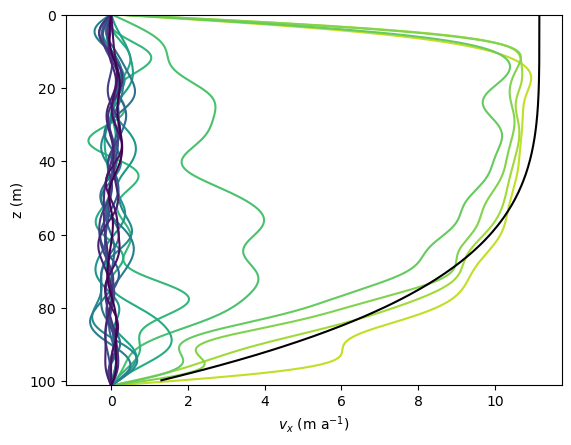

In [161]:
%matplotlib inline

t = np.arange(0, 21) * (eps.t[1] - eps.t[0]).values
means = fields[:, 0].mean(axis=-1)/t[:, None] * dx
depth = np.linspace(0, maxT * vel, 420)


Umean = U_x[:, 200:801].mean(axis=1)
from scipy.interpolate import interp1d
f_U = interp1d(np.linspace(100, 0, 100), Umean, bounds_error=False)

cmap = plt.get_cmap('viridis')

colors = [cmap(i/len(t)) for i in range(len(t))][::-1]

errors = np.zeros(len(t))

fig, ax = plt.subplots()
for i in range(len(t)):
    ax.plot(means[i], depth, c=colors[i])
    err = np.sqrt(np.nanmean(np.square(means[i] - f_U(depth))))
    errors[i] = err

ax.plot(f_U(depth), depth, c='k')

plt.gca().invert_yaxis()

plt.xlabel('$v_x$ (m a$^{-1}$)')
plt.ylabel('z (m)')
plt.ylim(maxT * vel, 0)

Text(0.5, 0, 'time (a)')

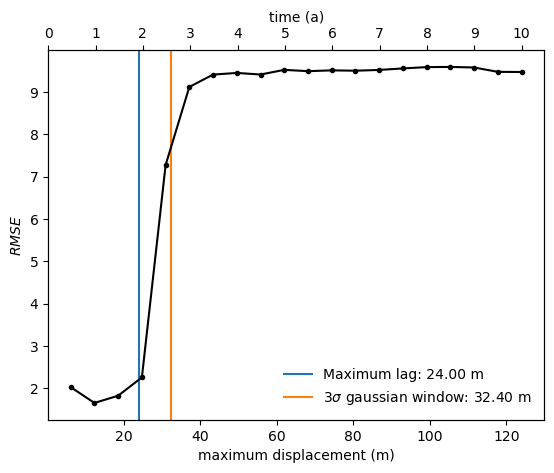

In [182]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(t * U_x.max(), errors, marker='.', c='k', zorder=10)
ylim = ax.get_ylim()
ax.axvline(maxlag, c='tab:blue', label=f'Maximum lag: {maxlag:.2f} m')
ax.axvline(3 * sigma, c='tab:orange', label=f'3$\sigma$ gaussian window: {3 * sigma:.2f} m')

ax.set_ylabel('$RMSE$')
ax.set_xlabel('maximum displacement (m)')


ax.legend(frameon=False)

ax2 = plt.twiny()
ax2.plot(t, errors, c='none')
ax2.set_xticks(t[::2])
ax2.set_xlabel('time (a)')

In [191]:
from scipy.interpolate import RegularGridInterpolator

x = np.linspace(0, 500, 1000)
z = np.linspace(100, 0, 100)
f = RegularGridInterpolator((z, x), U_x, bounds_error=False, fill_value=None)

_, _, nz, nx = fields.shape
zg = np.linspace(maxT * vel, 0, nz)
xg = np.linspace(100, 400, nx)

xg, zg = np.meshgrid(xg, zg)
U_x_proj = f((zg, xg))[::-1]

t = np.arange(0, 21) * (eps.t[1] - eps.t[0]).values
errors2d =  U_x_proj - fields[:, 0]/t[:, None, None] * dx
emax = np.abs(errors2d[np.isfinite(errors)]).max()
print(errors.shape)


(21,)


C:\Users\alexi\AppData\Local\Temp\ipykernel_19960\1462782766.py:15: RuntimeWarning: divide by zero encountered in divide
  errors2d =  U_x_proj - fields[:, 0]/t[:, None, None] * dx


In [197]:
%matplotlib qt
from matplotlib.animation import FuncAnimation, FFMpegWriter


fig = plt.figure(figsize=(8, 8))

width = 0.8
height = 0.44
ax0 = fig.add_axes([(1 - width)/2, 0.95 - height, width, height])

ax0.xaxis.tick_top()

ti = 1
text = ax0.text(0.01, 0.01, f't = {eps.t[ti].values} a', ha='left', va='bottom', transform=ax0.transAxes)

simul_im = ax0.imshow(simulations[ti].T, vmin=-gprmax, vmax=gprmax, cmap='Greys', extent=[100, 400, maxT * vel, 0], aspect='auto')
eps_im = ax0.imshow(eps[ti][::-1], extent=[0, 500, 100, 0], aspect='auto', alpha=0.3)

x0 = fig.transFigure.inverted().transform(ax0.transData.transform([100, 0]))[0]
x1 = fig.transFigure.inverted().transform(ax0.transData.transform([400, 0]))[0]

bbox = ax0.get_window_extent().transformed(fig.transFigure.inverted())
ax1 = fig.add_axes([x0, 0.95 - 2*height - 0.01, x1 - x0, height])

err_im = ax1.imshow(errors2d[ti], extent=[100, 400, maxT * vel, 0], aspect='auto', vmin=-emax, vmax=emax, cmap='jet')
ax1.set_xlabel('x (m)')

bbox = ax1.get_window_extent().transformed(fig.transFigure.inverted())
cax = fig.add_axes([bbox.x1 + (bbox.x1 - bbox.x0) * 0.05, bbox.y0, 0.025, bbox.y1 - bbox.y0])
cb = plt.colorbar(err_im, cax=cax)
cb.ax.set_ylabel('error (m a$^{-1}$)', rotation=270, va='bottom')

def update(ti):

    simul_im.set_data(simulations[ti].T)
    eps_im.set_data(eps[ti][::-1])
    err_im.set_data(errors2d[ti])

    text.set_text(f't = {eps.t[ti].values} a')

    return simul_im, eps_im, err_im

timesteps = np.arange(1, 21)
anim = FuncAnimation(fig, update, frames=timesteps, interval=3e3)
FFwriter = FFMpegWriter(fps=4, codec='h264', bitrate=1e6)
#anim.save('powerpoints/figures/propagation_lcc_error.gif', writer=FFwriter)

In [177]:
%matplotlib qt
from matplotlib.animation import FuncAnimation, FFMpegWriter

rel_errors2d = 100 * np.abs(errors2d/U_x_proj)
relemax = np.quantile(rel_errors2d[np.isfinite(rel_errors2d)], 0.90)

fig = plt.figure(figsize=(8, 8))

width = 0.8
height = 0.44
ax0 = fig.add_axes([(1 - width)/2, 0.95 - height, width, height])

ax0.xaxis.tick_top()

ti = 1
text = ax0.text(0.01, 0.01, f't = {eps.t[ti].values} a', ha='left', va='bottom', transform=ax0.transAxes)

simul_im = ax0.imshow(simulations[ti].T, vmin=-gprmax, vmax=gprmax, cmap='Greys', extent=[100, 400, maxT * vel, 0], aspect='auto')
eps_im = ax0.imshow(eps[ti][::-1], extent=[0, 500, 100, 0], aspect='auto', alpha=0.3)

x0 = fig.transFigure.inverted().transform(ax0.transData.transform([100, 0]))[0]
x1 = fig.transFigure.inverted().transform(ax0.transData.transform([400, 0]))[0]

bbox = ax0.get_window_extent().transformed(fig.transFigure.inverted())
ax1 = fig.add_axes([x0, 0.95 - 2*height - 0.01, x1 - x0, height])

err_im = ax1.imshow(rel_errors2d[ti], extent=[100, 400, maxT * vel, 0], aspect='auto', vmin=0, vmax=relemax, cmap='Reds')
ax1.set_xlabel('x (m)')

bbox = ax1.get_window_extent().transformed(fig.transFigure.inverted())
cax = fig.add_axes([bbox.x1 + (bbox.x1 - bbox.x0) * 0.05, bbox.y0, 0.025, bbox.y1 - bbox.y0])
cb = plt.colorbar(err_im, cax=cax)
cb.ax.set_ylabel('relative error (%)', rotation=270, va='bottom')

def update(ti):

    simul_im.set_data(simulations[ti].T)
    eps_im.set_data(eps[ti][::-1])
    err_im.set_data(rel_errors2d[ti])

    text.set_text(f't = {eps.t[ti].values} a')

    return simul_im, eps_im, err_im

timesteps = np.arange(1, 21)
anim = FuncAnimation(fig, update, frames=timesteps, interval=1e3)
FFwriter = FFMpegWriter(fps=4, codec='h264', bitrate=1e6)
anim.save('powerpoints/figures/propagation_lcc_relerror.gif', writer=FFwriter)